In [1]:
import pandas as pd
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters

learning_rate = 0.00001
epoches = 10000

In [3]:
train = pd.read_csv('./train.csv') # initialize train data
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1) # drop unused columns
train = train.dropna() # drop nan
train['Pclass'] = pd.to_numeric(train['Pclass']) # cast to int

#optimize Age
maxAge = max(train['Age'])
train['Age'] = round(train['Age']/maxAge, 2)

# optimize Fare
train['Fare'] = round(np.log10(train['Fare']+1), 2)

# optimize Pclass
train['Pclass_1'] = np.where(train['Pclass']==1, 1, 0)
train['Pclass_2'] = np.where(train['Pclass']==2, 1, 0)

# optimize gender
train['Sex'] = np.where(train['Sex']=='male',1,0)
train.rename(columns={'Sex' : 'Male'}, inplace=True)

# optimize embarked
train['Embark_S'] = np.where(train['Embarked']=='S',1,0)
train['Embark_C'] = np.where(train['Embarked']=='C',1,0)

# add ones
train['Ones'] = 1

In [4]:
final_data = train[['SibSp', 'Parch', 'Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Embark_S', 'Embark_C', 'Male', 'Ones']]
w = np.array([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01])

Loss: 107.97161865234375


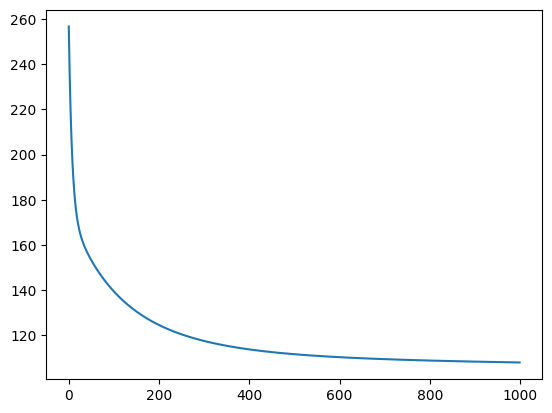

In [5]:
# data
final_data_t = torch.Tensor(final_data.values)       ; final_data_t.requires_grad = True
ground_truth = torch.Tensor(train['Survived'].values)

# weights
weights = torch.Tensor(w)                                ; weights.requires_grad = True
loss_values = []

for i in range(epoches):
    
    # Forward Pass
    predictions = torch.sum((final_data_t * weights), dim=1)
    # predictions = torch.tanh(predictions)
    
    # Loss
    loss = torch.sum((predictions - ground_truth) ** 2)
    loss_values.append(loss.data.item())
    
    # Backward pass
    loss.backward()
    
    # Nudge the gradients
    with torch.no_grad():
        weights -= learning_rate * weights.grad
    
    # Reset Gradients
    weights.grad.zero_()

print('Loss:', loss.data.item()) # print loss
plt.plot([i for i in range(len(loss_values))], loss_values)
plt.show()

### Test

In [6]:
test = pd.read_csv('./test.csv') # initialize test data
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1) # drop unused columns
test = test.dropna() # drop nan
test['Pclass'] = pd.to_numeric(test['Pclass']) # cast to int

#optimize Age
maxAge = max(test['Age'])
test['Age'] = round(test['Age']/maxAge, 2)

# optimize Fare
test['Fare'] = round(np.log10(test['Fare']+1), 2)

# optimize Pclass
test['Pclass_1'] = np.where(test['Pclass']==1, 1, 0)
test['Pclass_2'] = np.where(test['Pclass']==2, 1, 0)

# optimize gender
test['Sex'] = np.where(test['Sex']=='male',1,0)
test.rename(columns={'Sex' : 'Male'}, inplace=True)

# optimize embarked
test['Embark_S'] = np.where(test['Embarked']=='S',1,0)
test['Embark_C'] = np.where(test['Embarked']=='C',1,0)

# add ones
test['Ones'] = 1

In [7]:
test_data = test[['SibSp', 'Parch', 'Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Embark_S', 'Embark_C', 'Male', 'Ones']]
test_data = torch.Tensor(test_data.values)


weights = torch.Tensor(weights)    

In [8]:
predictions = torch.sum((test_data * weights), dim=1)
print(np.round(predictions.detach()))

tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 0., 0., 1., 1., -0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
        0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
        0., 0., 0., 1., 0., 1., 1., 0.,

In [9]:
pred = np.round(predictions.detach().numpy())
survived = test['Survived'].to_numpy()
loss = np.abs(pred - survived)
new_data = {
    'predictions' : pred,
    'survived' : survived,
    'loss' : loss
}
new_data = pd.DataFrame(new_data)

accurate_preds = new_data[new_data['loss'] == 0]
len(accurate_preds['loss'].to_numpy()) / 331 * 100

90.6344410876133